<a href="https://colab.research.google.com/github/nana881023/Financial_Big_Data_Analysis/blob/main/Week6_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1.ARIMA模型

### yfinance
- 下載2330從2024.1.1到今天的資料
- 要輸出成表格
- 包含日期、開、高、低、收、量

In [1]:
# 安裝必要的套件，yfinance 用於下載股票資料，statsmodels 用於建立 ARIMA 模型
!pip install yfinance statsmodels matplotlib  # 安裝 yfinance、statsmodels、matplotlib 套件

In [2]:
import yfinance as yf  # yfinance：下載股票數據
import pandas as pd  # pandas：數據處理
from datetime import datetime  # datetime：用於處理日期

In [3]:
# 股票
stock_id="2330.TW"
start_date="2024-01-01" # 從2324.01.01開始
end_date=datetime.today().strftime("%Y-%m-%d")  # 今天

# 下載股票資料
data=yf.download(stock_id,start=start_date,end=end_date)

data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-01-02,590.0,593.0,589.0,593.0,585.360901,26059058
2024-01-03,584.0,585.0,576.0,578.0,570.554199,37106763
2024-01-04,580.0,581.0,577.0,580.0,572.528381,15309129
2024-01-05,578.0,580.0,574.0,576.0,568.579895,18158971
2024-01-08,582.0,585.0,579.0,583.0,575.489807,17761275
...,...,...,...,...,...,...
2024-10-15,1050.0,1075.0,1050.0,1070.0,1070.000000,42850176
2024-10-16,1040.0,1070.0,1035.0,1045.0,1045.000000,52652149
2024-10-17,1050.0,1055.0,1030.0,1035.0,1035.000000,54173771


In [4]:
# 使用收盤價作為模型的資料來源
close_prices = data['Close'].dropna()  # 移除缺失值，並只取收盤價

# 計算總天數
total_days = len(close_prices)
print(f"總天數: {total_days}")  # 印出總天數

# 顯示資料的前幾筆
close_prices.head()  # 查看前幾筆資料

總天數: 192


,Close
Date,
2024-01-02,593.0
2024-01-03,578.0
2024-01-04,580.0
2024-01-05,576.0
2024-01-08,583.0


### 資料分割
- 拆成7:3

In [5]:
# 將最後30天作為預測集，其餘的作為訓練集
train_data = close_prices[:-30]  # 剩餘資料作為訓練集
test_data = close_prices[-30:]   # 最後30天作為測試集

# 印出資料集大小
print(f"訓練集大小: {len(train_data)}")
print(f"測試集大小: {len(test_data)}")

訓練集大小: 162
測試集大小: 30


### ARIMA
- 建立ARIMA模型並進行預測

In [6]:
import itertools  # 用於產生參數組合
import warnings  # 用於控制警告訊息
import numpy as np  # 用於數值計算
from statsmodels.tsa.arima.model import ARIMA  # ARIMA 模型
from sklearn.metrics import mean_squared_error  # 計算 RMSE

# 關閉警告訊息
warnings.filterwarnings('ignore')

# 設定參數範圍
p_range = range(0, 3)  # p 參數範圍 0-3
d_range = range(0, 2)  # d 參數範圍 0-2
q_range = range(0, 3)  # q 參數範圍 0-3

# 生成所有可能的參數組合
pdq = list(itertools.product(p_range, d_range, q_range))

# 初始化最佳參數
best_rmse = float('inf')
best_params = None

# 測試每個參數組合
for param in pdq:
    try:
        model = ARIMA(train_data, order=param)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(test_data))
        rmse = np.sqrt(mean_squared_error(test_data.values, forecast))

        if rmse < best_rmse:
            best_rmse = rmse
            best_params = param

    except:
        continue

print(f"最佳參數組合: ARIMA{best_params}")
print(f"RMSE: {best_rmse:.2f}")

最佳參數組合: ARIMA(2, 1, 2)
RMSE: 66.66


In [7]:
# 確保預測值是數值型態
forecast = pd.Series(forecast, dtype=float)  # 轉換為浮點數類型

# 建立預測序列，使用測試集的索引
forecast.index = test_data.index  # 設定正確的時間索引

# 建立比較用的 DataFrame
comparison_df = pd.DataFrame({
    'Actual': test_data,
    'Predicted': forecast.round(2)  # 四捨五入到小數點後兩位
})

# 顯示前幾筆結果來驗證
print("預測結果比較表:")
print(comparison_df)

預測結果比較表:
            Actual  Predicted
Date                         
2024-09-04   889.0     948.79
2024-09-05   902.0     949.73
2024-09-06   918.0     939.99
2024-09-09   899.0     952.74
2024-09-10   904.0     944.21
2024-09-11   901.0     943.94
2024-09-12   940.0     952.50
2024-09-13   947.0     940.76
2024-09-16   947.0     949.00
2024-09-18   941.0     948.71
2024-09-19   960.0     941.22
2024-09-20   973.0     951.99
2024-09-23   977.0     944.08
2024-09-24   987.0     944.84
2024-09-25  1005.0     951.36
2024-09-26  1015.0     941.49
2024-09-27  1000.0     949.07
2024-09-30   957.0     947.91
2024-10-01   972.0     942.27
2024-10-04   977.0     951.29
2024-10-07  1005.0     944.06
2024-10-08  1010.0     945.54
2024-10-09  1020.0     950.40
2024-10-11  1045.0     942.17
2024-10-14  1045.0     949.04
2024-10-15  1070.0     947.30
2024-10-16  1045.0     943.15
2024-10-17  1035.0     950.63
2024-10-18  1085.0     944.13
2024-10-21  1085.0     946.07


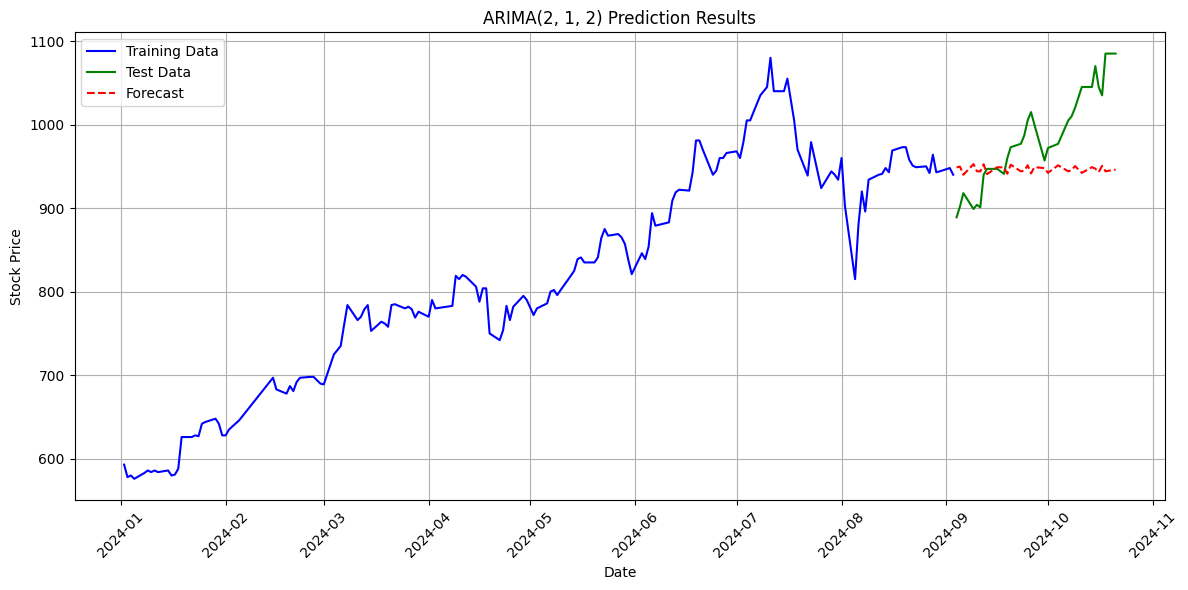

In [8]:
import matplotlib.pyplot as plt

# 建立視覺化圖表
plt.figure(figsize=(12, 6))  # 設定圖表大小為 12x6

# 繪製三條線
plt.plot(train_data.index, train_data.values,
         label='Training Data', color='blue')  # 繪製訓練資料
plt.plot(test_data.index, test_data.values,
         label='Test Data', color='green')  # 繪製測試資料
plt.plot(test_data.index, forecast,
         label='Forecast', color='red',
         linestyle='--')  # 繪製預測結果，使用虛線

# 設定圖表標題和標籤
plt.title(f'ARIMA{best_params} Prediction Results')  # 設定標題，顯示模型參數
plt.xlabel('Date')  # 設定 x 軸標籤
plt.ylabel('Stock Price')  # 設定 y 軸標籤
plt.legend()  # 顯示圖例
plt.grid(True)  # 顯示網格

# 旋轉 x 軸日期標籤，避免重疊
plt.xticks(rotation=45)

# 自動調整版面配置，確保所有元素都能完整顯示
plt.tight_layout()

# 顯示圖表
plt.show()

- 季節性SARIMA

最佳非季節性參數 SARIMA(0, 1, 2)
最佳季節性參數 (0, 1, 1, 5)
RMSE: 38.59


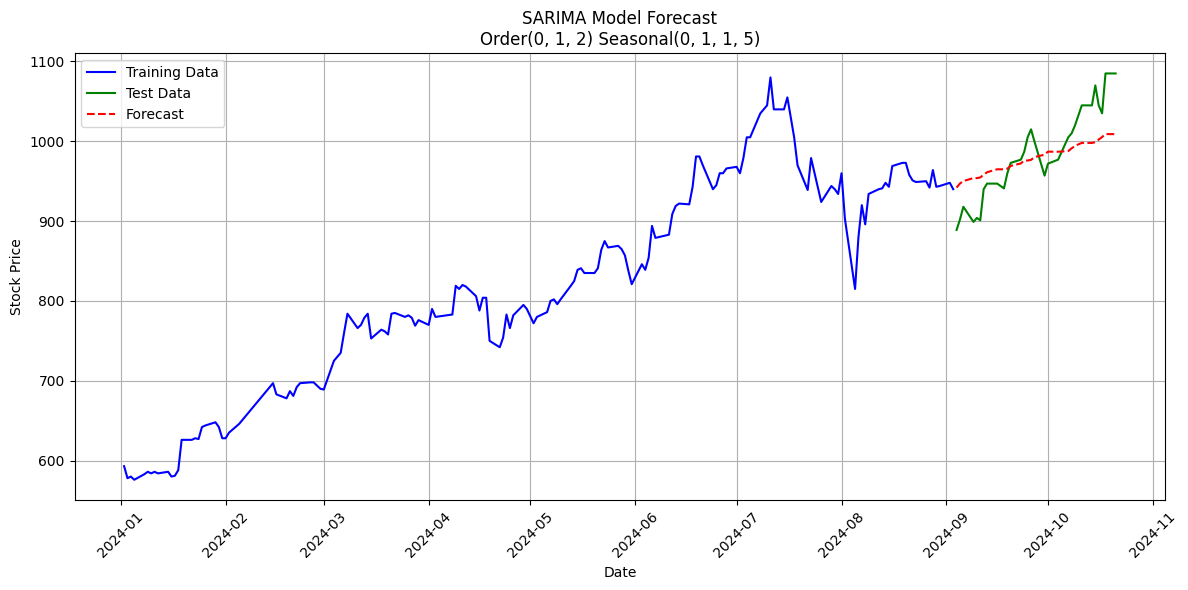

In [9]:
import itertools  # 用於產生參數組合
import warnings  # 用於控制警告訊息
import numpy as np  # 用於數值計算
from statsmodels.tsa.statespace.sarimax import SARIMAX  # SARIMA 模型
from sklearn.metrics import mean_squared_error  # 計算 RMSE
import matplotlib.pyplot as plt  # 用於繪圖

# 關閉警告訊息
warnings.filterwarnings('ignore')

# 設定非季節性參數範圍
p_range = range(0, 3)  # AR項次數範圍
d_range = range(0, 2)  # 差分次數範圍
q_range = range(0, 3)  # MA項次數範圍

# 設定季節性參數範圍
P_range = range(0, 2)  # 季節性AR項次數範圍
D_range = range(0, 2)  # 季節性差分次數範圍
Q_range = range(0, 2)  # 季節性MA項次數範圍
s = 5  # 季節性週期，這裡設為5因為是股票交易日

# 生成所有可能的參數組合
pdq = list(itertools.product(p_range, d_range, q_range))  # 非季節性參數組合
seasonal_pdq = list(itertools.product(P_range, D_range, Q_range))  # 季節性參數組合

# 初始化最佳參數
best_rmse = float('inf')
best_params = None
best_seasonal_params = None
best_model = None

# 測試每個參數組合
for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            # 建立季節性參數
            seasonal_order = seasonal_param + (s,)

            # 建立和訓練模型
            model = SARIMAX(train_data,
                          order=param,
                          seasonal_order=seasonal_order)
            model_fit = model.fit(disp=False)

            # 預測
            forecast = model_fit.forecast(steps=len(test_data))

            # 計算 RMSE
            rmse = np.sqrt(mean_squared_error(test_data.values, forecast))

            # 更新最佳參數
            if rmse < best_rmse:
                best_rmse = rmse
                best_params = param
                best_seasonal_params = seasonal_order
                best_model = model_fit

        except:
            continue

# 輸出結果
print(f"最佳非季節性參數 SARIMA{best_params}")
print(f"最佳季節性參數 {best_seasonal_params}")
print(f"RMSE: {best_rmse:.2f}")

# 使用最佳模型進行預測
forecast = best_model.forecast(steps=len(test_data))

# 繪製結果
plt.figure(figsize=(12, 6))

# 繪製訓練資料
plt.plot(train_data.index, train_data,
         label='Training Data', color='blue')

# 繪製測試資料
plt.plot(test_data.index, test_data,
         label='Test Data', color='green')

# 繪製預測值
plt.plot(test_data.index, forecast,
         label='Forecast', color='red',
         linestyle='--')

# 設定圖表
plt.title(f'SARIMA Model Forecast\nOrder{best_params} Seasonal{best_seasonal_params}')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# 調整版面
plt.tight_layout()
plt.show()


## 2.量化交易策略

### yfinance
- 下載2330從2024.1.1到今天的資料
- 要輸出成表格
- 包含日期、開、高、低、收、量

In [10]:
# 安裝必要的套件，yfinance 用於下載股票資料，statsmodels 用於建立 ARIMA 模型
!pip install yfinance statsmodels matplotlib  # 安裝 yfinance、statsmodels、matplotlib 套件

In [11]:
import yfinance as yf  # 匯入 yfinance 套件
from datetime import datetime  # 匯入日期時間處理套件
import pandas as pd  # 匯入 pandas 套件
import numpy as np  # 匯入 numpy 套件
import matplotlib.pyplot as plt  # 匯入繪圖套件

In [12]:
# 股票
stock_id="2330.TW"
start_date="2024-01-01" # 從2324.01.01開始
end_date=datetime.today().strftime("%Y-%m-%d")  # 今天

# 下載股票資料
data=yf.download(stock_id,start=start_date,end=end_date)

data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-01-02,590.0,593.0,589.0,593.0,585.360901,26059058
2024-01-03,584.0,585.0,576.0,578.0,570.554199,37106763
2024-01-04,580.0,581.0,577.0,580.0,572.528381,15309129
2024-01-05,578.0,580.0,574.0,576.0,568.579895,18158971
2024-01-08,582.0,585.0,579.0,583.0,575.489807,17761275
...,...,...,...,...,...,...
2024-10-15,1050.0,1075.0,1050.0,1070.0,1070.000000,42850176
2024-10-16,1040.0,1070.0,1035.0,1045.0,1045.000000,52652149
2024-10-17,1050.0,1055.0,1030.0,1035.0,1035.000000,54173771


### 移動平均線交叉策略

- 黃金交叉（買入訊號）：

  - 當 5 日均線從下方突破 20 日均線
  - 表示短期趨勢轉強，可能開始上漲
  - 系統產生買入訊號 (Signal = 1)

- 死亡交叉（賣出訊號）：

  - 當 5 日均線從上方跌破 20 日均線
  - 表示短期趨勢轉弱，可能開始下跌
  - 系統產生賣出訊號 (Signal = -1)

In [13]:
# 計算移動平均線
data['SMA5'] = data['Close'].rolling(window=5).mean()  # 計算 5 日移動平均線
data['SMA20'] = data['Close'].rolling(window=20).mean()  # 計算 20 日移動平均線

# 產生交易訊號
data['Signal'] = 0  # 建立訊號欄位，預設為 0
# 當 5 日線突破 20 日線時，產生買入訊號 (1)
data.loc[data['SMA5'] > data['SMA20'], 'Signal'] = 1
# 當 5 日線跌破 20 日線時，產生賣出訊號 (-1)
data.loc[data['SMA5'] < data['SMA20'], 'Signal'] = -1

# 計算實際持倉部位
data['Position'] = data['Signal'].shift(1)  # 訊號延遲一天再執行
data['Position'] = data['Position'].fillna(0)  # 將 NaN 值填充為 0

In [14]:
# 設定初始資金
initial_capital = 100000  # 設定初始資金為 100,000

# 計算每日報酬
data['Returns'] = data['Close'].pct_change()  # 計算股價報酬率
data['Strategy_Returns'] = data['Position'] * data['Returns']  # 計算策略報酬率

# 計算累積報酬
data['Cumulative_Returns'] = (1 + data['Returns']).cumprod()  # 計算股價累積報酬
data['Strategy_Cumulative_Returns'] = (1 + data['Strategy_Returns']).cumprod()  # 計算策略累積報酬

# 計算策略績效
total_return = (data['Strategy_Cumulative_Returns'].iloc[-1] - 1) * initial_capital  # 計算總報酬
total_return_pct = (data['Strategy_Cumulative_Returns'].iloc[-1] - 1) * 100  # 計算報酬率百分比

print(f"總資金報酬: {total_return:.2f} 元")  # 印出總資金報酬
print(f"報酬率: {total_return_pct:.2f}%")  # 印出報酬率百分比

總資金報酬: 11252.46 元
報酬率: 11.25%


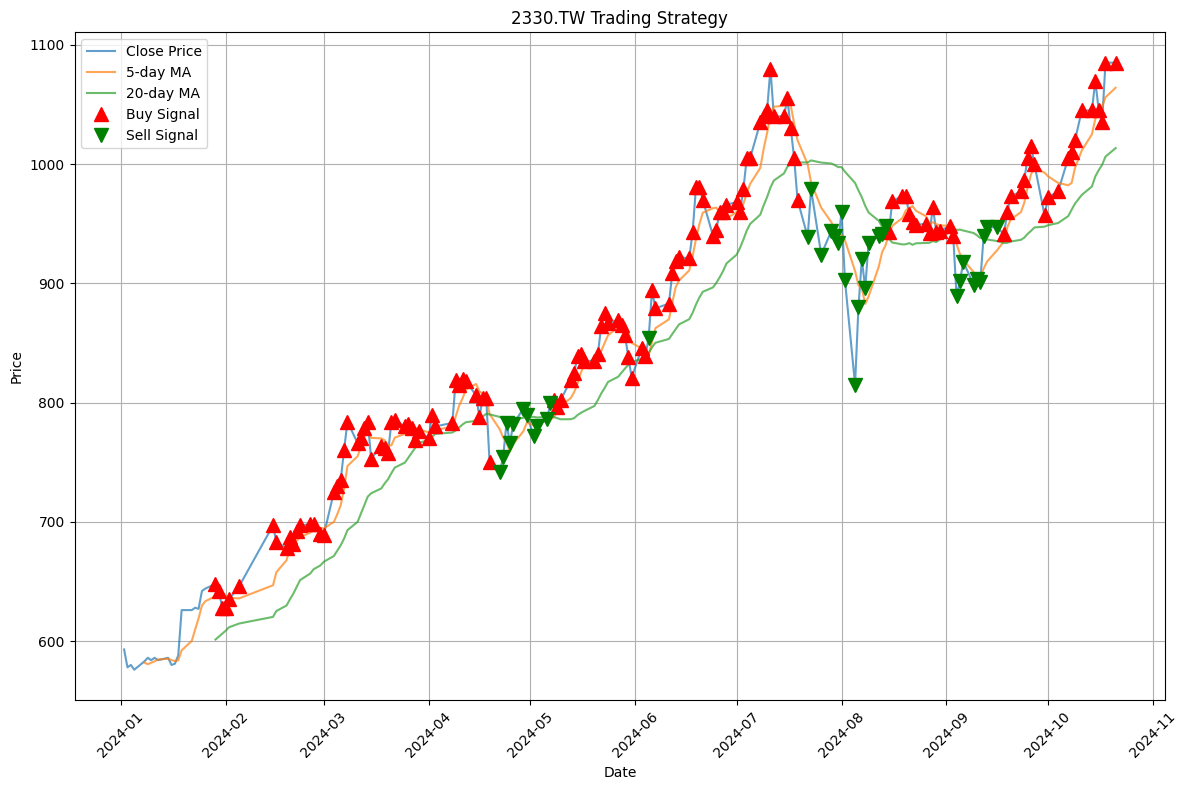

In [15]:
# 建立圖表
plt.figure(figsize=(12, 8))  # 設定圖表大小

# 繪製股價和移動平均線
plt.plot(data.index, data['Close'], label='Close Price', alpha=0.7)  # 繪製收盤價
plt.plot(data.index, data['SMA5'], label='5-day MA', alpha=0.7)  # 繪製 5 日線
plt.plot(data.index, data['SMA20'], label='20-day MA', alpha=0.7)  # 繪製 20 日線

# 標記買賣點
buy_signals = data[data['Signal'] == 1].index  # 找出買入訊號點
sell_signals = data[data['Signal'] == -1].index  # 找出賣出訊號點

# 在圖上標記買賣點
plt.plot(buy_signals, data.loc[buy_signals, 'Close'], '^',
         markersize=10, color='r', label='Buy Signal')  # 標記買點
plt.plot(sell_signals, data.loc[sell_signals, 'Close'], 'v',
         markersize=10, color='g', label='Sell Signal')  # 標記賣點

# 設定圖表格式
plt.title(f'{stock_id} Trading Strategy')  # 設定標題
plt.xlabel('Date')  # 設定 x 軸標籤
plt.ylabel('Price')  # 設定 y 軸標籤
plt.legend()  # 顯示圖例
plt.grid(True)  # 顯示格線
plt.xticks(rotation=45)  # 旋轉 x 軸日期標籤
plt.tight_layout()  # 自動調整版面
plt.show()  # 顯示圖表